# ***Capstone Project Modul 2 - Data Analysis***

**Deryl Baharudin Sopandi**

Job Connector Data Science and Machine Learning

After Hour Video Learning

## **1. Data Understanding**

## Context
Sebuah perusahaan memiliki database HR yang berisi informasi lokasi cabang perusahaan, data karyawan, gaji, dan jabatan pekerjaan.

## Database Information
Sumber Database : https://drive.google.com/file/d/1XfhOHYKzW7Cz1RNHlknJI6Lz7LLSi5EI/view?usp=sharing

In [36]:
from IPython.display import Image
Image(url='HR ERD.gif')

Database HR terdiri dari 8 tabel, yaitu:
1. region       : menyimpan informasi mengenai region perusahaan
2. countries    : menyimpan informasi mengenai data negara di setiap region perusahaan
3. departments  : menyimpan informasi log manager dalam setiap departemen
4. job_history  : menyimpan informasi data karyawan yang pernah/sedang bekerja di setiap departemen
5. employees    : menyimpan informasi identitas karyawan, hiring date, jabatan, gaji, manager, dan departemen
6. locations    : menyimpan informasi lokasi/alamat kantor cabang
7. jobs         : menyimpan informasi setiap posisi jabatan pekerjaan dan range gaji
8. job_grades   : menyimpan informasi golongan jabatan dan range gaji

## **2. Database**

### Import Libraries
Pada bagian ini, akan diimport libraries 

In [37]:
# Import Modules
import pandas as pd
import numpy as np
import mysql.connector as sqlcon

### Connecting to MySQL
Pada bagian ini, akan dihubungkan dengan ``MySQL`` pada koneksi lokal menggunakan 

In [38]:
# Connect To Database

mydb = sqlcon.connect(
    host = 'localhost',
    user = 'root',
    passwd = 'derylbaharudin',
    database = 'human_resource'
)

### Convert to DataFrame
Selain melakukan koneksi ke database, hal lain yang perlu dilakukan pada bagian awal ini adalah membuat sebuah fungsi untuk menuliskan ``query`` yang kemudian akan disimpan dalam bentuk DataFrame. Tujuannya adalah agar data hasil ``query`` yang dibuat dapat disimpan dan digunakan untuk keperluan analisis data. Nantinya, di sini terdapat 2 query untuk mengambil data-data yang ada di database, bukan hanya berasal dari 1 tabel, tapi juga akan melibatkan hubungan antar tabel.

In [39]:
# Query Function

curs = mydb.cursor()

def sql_table (query) :
    curs.execute (query)
    result = curs.fetchall()
    tabel1 = pd.DataFrame(result, columns=curs.column_names)
    return tabel1

### Questions Formulation
Membuat formulasi masalah untuk dianalisis dan dicari insight yang ditemukan dari database yang ada. Pertanyaan untuk pedoman analisis antara lain:
1. Profiling Karyawan. **(Python)**
- Karyawan terbanyak untuk tiap region, negara dan cabang?
- Bagaimana perbandingan rata-rata gaji karyawan di tiap posisi antara actual dan kisaran range perusahaan?

2. Manager profiling. **(Tableau)**
- Berapa jumlah personil yang disupervisi oleh setiap manager?
- Berapa jumlah manager di tiap kantor cabang?
- Rata-rata gaji manager di tiap kantor cabang?

### Preparing DataFrame with Common Table Expression (CTE)

#### 1. Data Detail Karyawan
Data pertama ini merupakan data utama yang nantinya akan dianalisa lebih lanjut. Data ini merupakan gabungan dari 4 tabel, yaitu tabel ```regions```, ```countries```, ```locations```, ```employees```, ```jobs``` dan ```departments``` untuk tabel 1 dan ```job_history``` untuk tabel 2. Masing-masing dari setiap tabel tersebut diambil beberapa kolomnya dan tidak diambil secara keseluruhan. Informasi-informasi yang dianggap penting saja lah yang diambil. Informasi yang diambil antara lain adalah :
- region_name dari tabel regions
- country name dari tabel countries
- city dari tabel locations
- department_name dari tabel departments
- employee_id dari tabel employees
- hire_date dari tabel employees
- job_title dari tabel jobs
- min_salary dari tabel jobs
- max_salary dari tabel jobs
- salary dari tabel employees
- manager_id dari tabel employees

#### 2. Data Detail Job History
- start_date dari tabel job_history
- end_date dari tabel job_history


In [40]:
# With CTE
tabel1 = sql_table (
    '''
    WITH 
    locations_table AS (
        SELECT c.country_name, r.region_name, l.location_id, l.city
        FROM countries c
        INNER JOIN regions r on c.region_id = r.region_id
        INNER JOIN locations l on c.country_id = l.country_id),
    employees_table AS (
        SELECT e.employee_id, e.hire_date, e.salary, e.manager_id, 
        d.department_name, d.location_id,
        j.job_title, j.min_salary, j.max_salary
        FROM employees e
        INNER JOIN departments d on e.department_id = d.department_id
        INNER JOIN jobs j on e.job_id = j.job_id)
    SELECT *
    FROM locations_table t1
    LEFT JOIN employees_table t2 on t1.location_id = t2.location_id;
    '''
)
tabel1.head()

,country_name,region_name,location_id,city,employee_id,hire_date,salary,manager_id,department_name,location_id,job_title,min_salary,max_salary
0,Italy,Europe\r,1000,Roma,None,None,None,None,None,None,None,None,None
1,Italy,Europe\r,1100,Venice,None,None,None,None,None,None,None,None,None
2,Japan,Asia\r,1200,Tokyo,None,None,None,None,None,None,None,None,None
3,Japan,Asia\r,1300,Hiroshima,None,None,None,None,None,None,None,None,None
4,United States of America,Americas\r,1400,Southlake,103,1987-06-20,9000.00,102,IT,1400,Programmer,4000,10000


In [41]:
tabel2 = sql_table (
    '''
    SELECT job_title, ROUND((max_salary + min_salary)/2,0) AS AVG_salary
    FROM jobs;
    '''
)
tabel2.head()

,job_title,AVG_salary
0,President,30000
1,Administration Vice President,22500
2,Administration Assistant,4500
3,Finance Manager,12100
4,Accountant,6600


### Exploring Anomalies in DataFrame

Mencari nilai-nilai anomali yang ada di dataframe tabel1 dan tabel2 yaitu:
- missing values
- data formatting
- duplicated data
- outlier

In [42]:
tabel1.info()
tabel2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country_name     87 non-null     object
 1   region_name      87 non-null     object
 2   location_id      87 non-null     object
 3   city             87 non-null     object
 4   employee_id      72 non-null     object
 5   hire_date        72 non-null     object
 6   salary           72 non-null     object
 7   manager_id       72 non-null     object
 8   department_name  72 non-null     object
 9   location_id      72 non-null     object
 10  job_title        72 non-null     object
 11  min_salary       72 non-null     object
 12  max_salary       72 non-null     object
dtypes: object(13)
memory usage: 9.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 

**Melihat Data Sekilas Dari General Info**

- **Tabel 1**

Mari sejenak melihat apa yang ditampilkan pada general info yang disajikan di atas. Terlihat bahwa secara keseluruhan terdapat 87 baris data dengan total 12 kolom. Setiap kolomnya memiliki tipe data object, integer, dan float. Jika melihat informasi tersebut, tidak semua kolom atau feature yang memiliki data lengkap. Kita bisa lihat bahwa dari kolom ```employee_id``` sampai kolom terakhir memiliki null-value atau data kosong sejumlah 15 data entry. Sembilan kolom tersebut kehilangan 17.24% data. **Kesimpulanya adalah bahwa terdapat *missing value* di tabel 1 yang harus ditanggulangi.**

In [43]:
tabel1.isnull().sum()

country_name        0
region_name         0
location_id         0
city                0
employee_id        15
hire_date          15
salary             15
manager_id         15
department_name    15
location_id        15
job_title          15
min_salary         15
max_salary         15
dtype: int64

- **Tabel 2**

Terdapat 19 entries dan 2 kolom atau feature pada tabel 2 dimana untuk setiap kolom tidak ada null-value sehingga **Kesimpulanya adalah tidak terdapat *missing value* di tabel 2.**

#### 1. Missing Value
Terdapat missing value pada tabel 1 sebesar 17.24%. Untuk justifikasi, kita lihat dahulu data apa saja yang memiliki null-value.

In [44]:
# Data null-value
tabel1.dropna(inplace = True)

In [45]:
# Check kembali
tabel1.isnull().sum()

country_name       0
region_name        0
location_id        0
city               0
employee_id        0
hire_date          0
salary             0
manager_id         0
department_name    0
location_id        0
job_title          0
min_salary         0
max_salary         0
dtype: int64

In [46]:
tabel1.reset_index().head()

,index,country_name,region_name,location_id,city,employee_id,hire_date,salary,manager_id,department_name,location_id,job_title,min_salary,max_salary
0,4,United States of America,Americas\r,1400,Southlake,103,1987-06-20,9000.00,102,IT,1400,Programmer,4000,10000
1,5,United States of America,Americas\r,1400,Southlake,104,1987-06-21,6000.00,103,IT,1400,Programmer,4000,10000
2,6,United States of America,Americas\r,1400,Southlake,105,1987-06-22,4800.00,103,IT,1400,Programmer,4000,10000
3,7,United States of America,Americas\r,1400,Southlake,106,1987-06-23,4800.00,103,IT,1400,Programmer,4000,10000
4,8,United States of America,Americas\r,1400,Southlake,107,1987-06-24,4200.00,103,IT,1400,Programmer,4000,10000


#### 2. Data formatting
Terdapat anomali pada kolom region_name dimana seluruh region diakhiri dengan teks '\r'. dan juga terdapat data type yang tidak sesuai.

In [47]:
tabel1['region_name'] = tabel1['region_name'].str.replace('\r','')

In [48]:
tabel1.head()

,country_name,region_name,location_id,city,employee_id,hire_date,salary,manager_id,department_name,location_id,job_title,min_salary,max_salary
4,United States of America,Americas,1400,Southlake,103,1987-06-20,9000.00,102,IT,1400,Programmer,4000,10000
5,United States of America,Americas,1400,Southlake,104,1987-06-21,6000.00,103,IT,1400,Programmer,4000,10000
6,United States of America,Americas,1400,Southlake,105,1987-06-22,4800.00,103,IT,1400,Programmer,4000,10000
7,United States of America,Americas,1400,Southlake,106,1987-06-23,4800.00,103,IT,1400,Programmer,4000,10000
8,United States of America,Americas,1400,Southlake,107,1987-06-24,4200.00,103,IT,1400,Programmer,4000,10000


Terdapat juga format data type yang salah yaitu:
- kolom hire_date data type nya object seharusnya datetime
- kolom salary data type nya object seharusnya numeric
- kolom min_salary data type nya object seharusnya numeric
- olom max_salary data type nya object seharusnya numeric

In [49]:
# Change Datatype
tabel1['hire_date'] = pd.to_datetime(tabel1['hire_date'])
tabel1['salary'] = pd.to_numeric(tabel1['salary'])
tabel1['min_salary'] = pd.to_numeric(tabel1['min_salary'])
tabel1['max_salary'] = pd.to_numeric(tabel1['max_salary'])
tabel2['AVG_salary'] = pd.to_numeric(tabel2['AVG_salary'])

In [50]:
# Check
tabel1.head()

,country_name,region_name,location_id,city,employee_id,hire_date,salary,manager_id,department_name,location_id,job_title,min_salary,max_salary
4,United States of America,Americas,1400,Southlake,103,1987-06-20,9000.0,102,IT,1400,Programmer,4000.0,10000.0
5,United States of America,Americas,1400,Southlake,104,1987-06-21,6000.0,103,IT,1400,Programmer,4000.0,10000.0
6,United States of America,Americas,1400,Southlake,105,1987-06-22,4800.0,103,IT,1400,Programmer,4000.0,10000.0
7,United States of America,Americas,1400,Southlake,106,1987-06-23,4800.0,103,IT,1400,Programmer,4000.0,10000.0
8,United States of America,Americas,1400,Southlake,107,1987-06-24,4200.0,103,IT,1400,Programmer,4000.0,10000.0


In [51]:
# check juga tabel 2
tabel2.head()

,job_title,AVG_salary
0,President,30000.0
1,Administration Vice President,22500.0
2,Administration Assistant,4500.0
3,Finance Manager,12100.0
4,Accountant,6600.0


#### 3. Duplicated Data
Dilakukan pemeriksaan apakah ada data duplikat pada tabel 1 dan 2.

In [52]:
# Checking duplicated data in tabel 1
tabel1[tabel1.duplicated()]

,country_name,region_name,location_id,city,employee_id,hire_date,salary,manager_id,department_name,location_id,job_title,min_salary,max_salary


In [53]:
# Checking duplicated data in tabel 2
tabel2[tabel2.duplicated()]

,job_title,AVG_salary


**Kesimpulanya adalah tidak terdapat *duplicated data* di tabel 1 dan 2.**

#### 4. Outlier Data
Dilakukan pemeriksaan terhadap distribusi data setiap feature, kemudian diidentifikasi dan ditangani data-data outlier yang mungkin ada.

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

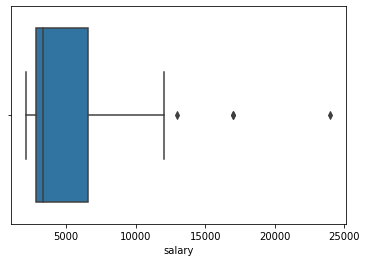

In [55]:
tabel1_outlier = sns.boxplot(x = tabel1['salary'])

Terdapat 3 data outlier untuk feature ``salary``. yaitu:

In [56]:
tabel1.sort_values(by='salary', ascending=False).head(3)[['job_title','salary']]

,job_title,salary
62,President,24000.0
64,Administration Vice President,17000.0
63,Administration Vice President,17000.0


Dapat dilihat bahwa ketiga outlier salary bisa diterima (logis) karena ketiga nya masing masing memiliki jabatan president, vice president, dan vice president sehingga data tidak dihapus dari dataframe.

### Conduct Data Analysis

Melakukan analisis data berdasarkan pertanyaan-pertanyaan yang sudah di formulasikan.

1. Profiling Karyawan.
- Karyawan terbanyak untuk tiap region, negara dan cabang?
- Rata-rata periode kerja terpanjang untuk tiap posisi pekerjaan?
- Karyawan dengan periode kerja terpanjang?
- Bagaimana distribusi gaji untuk setiap posisi pekerjaan?
- Pengeluaran untuk gaji karyawan terbesar di tiap negara?
- Bagaimana perbandingan rata-rata gaji karyawan di tiap posisi antara actual dan kisaran range perusahaan?

2. Manager profiling.
- Berapa jumlah personil yang disupervisi oleh setiap manager?
- Berapa jumlah manager di tiap kantor cabang?
- Rata-rata gaji manager di tiap kantor cabang?

### 1.1. Karyawan terbanyak untuk tiap region, negara dan cabang?


In [57]:
# Membuat tabel
tabel1_1 = tabel1.groupby(['region_name','country_name','city'])['employee_id'].sum().reset_index()
tabel1_1 = tabel1_1.sort_values(by='employee_id',ascending=False)
tabel1_1.columns = ['Region','Country','City','Total Employee']
tabel1_1

,Region,Country,City,Total Employee
2,Americas,United States of America,South San Francisco,7090
1,Americas,United States of America,Seattle,2276
3,Americas,United States of America,Southlake,525
0,Americas,Canada,Toronto,403
4,Europe,Germany,Munich,204
5,Europe,United Kingdom,London,203


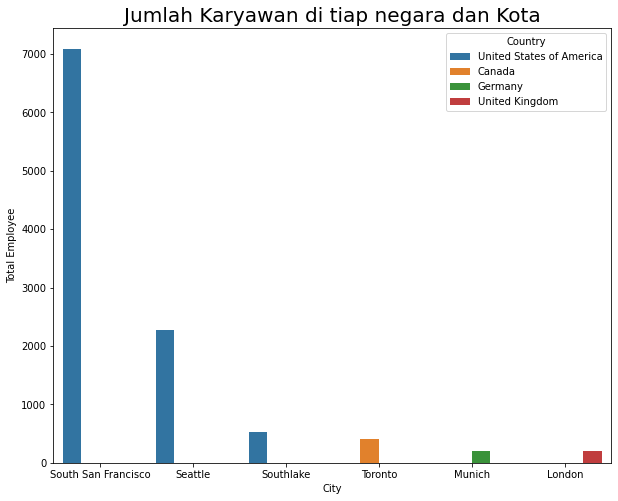

In [58]:
plt.figure(figsize=(10,8))
plt.title('Jumlah Karyawan di tiap negara dan Kota',size=20)
sns.barplot(data=tabel1_1, x='City', y='Total Employee', hue='Country')
plt.show()

Dari barplot di atas dapat disimpulkan bahwa South San Francisco memiliki Karyawan paling banyak yaitu 7090 karyawan, disusul dengan Seattle sebesar 2276 karyawan dan Southlake sebesar 525 karyawan. Untuk country yang memiliki paling banyak karyawan adalah United State of America karena ketiga perusahaan dengan karyawan terbesar terdapat pada negara tersebut.

### 1.2. Bagaimana perbandingan rata-rata gaji karyawan di tiap posisi antara actual dan kisaran range perusahaan?

In [59]:
# Membuat tabel
tabel1_2 = tabel1.merge(tabel2, how='inner', on='job_title')
tabel1_2 = tabel1_2.groupby(['job_title'])[['salary','AVG_salary']].mean().reset_index()
tabel1_2.columns = ['Jabatan Pekerjaan','Rata-rata actual','Kisaran Range Perusahaan']
tabel1_2['Perbedaan'] = tabel1_2['Rata-rata actual']-tabel1_2['Kisaran Range Perusahaan']
tabel1_2 = tabel1_2.sort_values(by='Perbedaan', ascending=False)
tabel1_2

,Jabatan Pekerjaan,Rata-rata actual,Kisaran Range Perusahaan,Perbedaan
11,Public Relations Representative,10000.0,7500.0,2500.0
10,Public Accountant,8300.0,6600.0,1700.0
0,Accountant,7920.0,6600.0,1320.0
6,Marketing Manager,13000.0,12000.0,1000.0
16,Stock Manager,7280.0,7000.0,280.0
5,Human Resources Representative,6500.0,6500.0,0.0
4,Finance Manager,12000.0,12100.0,-100.0
1,Accounting Manager,12000.0,12100.0,-100.0
2,Administration Assistant,4400.0,4500.0,-100.0
7,Marketing Representative,6000.0,6500.0,-500.0


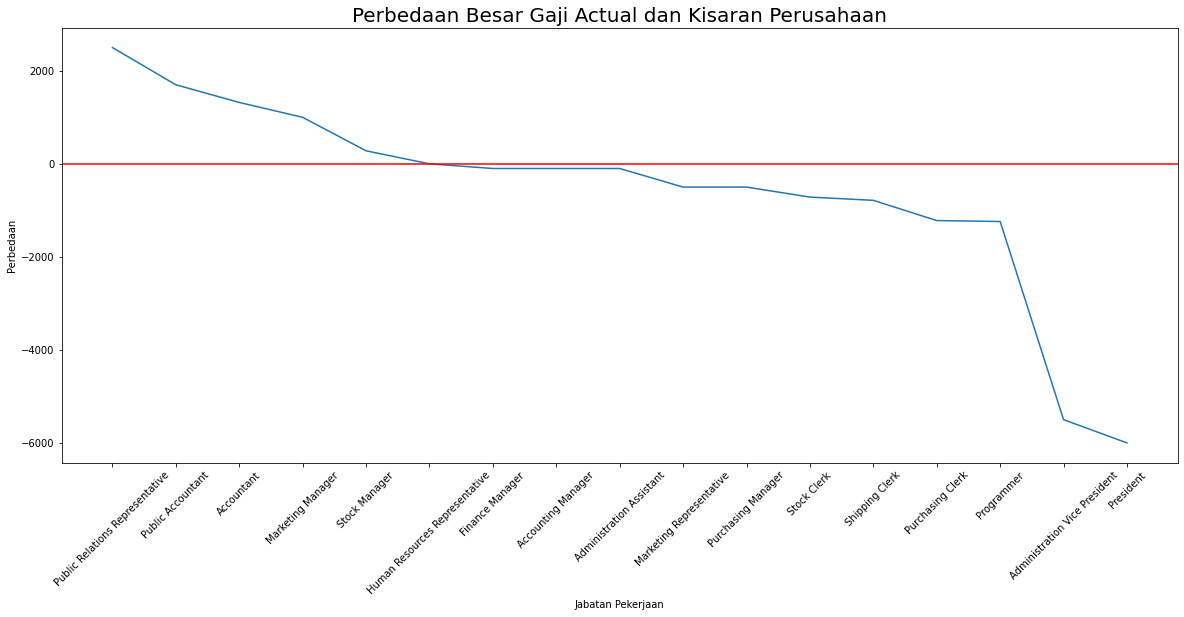

In [60]:
plt.figure(figsize=(20,8))
plt.title('Perbedaan Besar Gaji Actual dan Kisaran Perusahaan',size=20)
sns.lineplot(data=tabel1_2, x='Jabatan Pekerjaan', y='Perbedaan')
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(rotation=45)
plt.show()

Dari gambar di atas, Public Relations Representative memiliki rata-rata gaji lebih tinggi dibandingkan rata-rata gaji yang ditetapkan perusahaan, Human Resource Representative memiliki rata-rata gaji yang sama dengan rata-rata gaji yang ditetapkan perusahaan, sementara President memiliki gaji dibawah rata-rata gaji yang ditetapkan perusahaan.


### 2.1. Berapa jumlah personil yang disupervisi oleh setiap manager?

Analisis dilakukan menggunakan Tableau dengan mengkoneksikan Tableu melalui server MySQL.

In [61]:
Image(url='Distribusi Jumlah Karyawan yang disupervisi setiap manager.png')

Dari gambar di atas, manager dengan employee_id 120, 121, 122, 123, dan 124 memiliki jumlah karyawan yang disupervisi terbanyak dimana seluruhnya pada departemen nomor 50.

### 2.2. Berapa jumlah manager di tiap kantor cabang?

In [62]:
Image(url='Distribusi Jumlah Manager setiap kota.png')

Dari gambar di atas, South San Francisco memiliki jumlah manager terbanyak yaitu mencapai 90 manager, disusul dengan Toronto dan Seattle, yang paling sedikit pada Southlake yang hanya sebesar 5 manager.

### 2.3. Rata-rata gaji manager di tiap kantor cabang?

In [63]:
Image(url='Rata-rata Gaji Manager setiap Kota.png')

Dari gambar di atas, Manager-manager di Kota Seattle US memiliki rata-rata gaji tertinggi disusul oleh Toronto dan South San Francisco.

### Statistical Analysis

Melakukan analisis berdasarkan statistik data yang ada di database HR.

### 1. Desriptive Analysis
Descriptive analysis pada feature salary 

In [64]:
# Descriptive Analysis for Salary
tabel1['salary'].describe()

count       72.000000
mean      5276.388889
std       4060.406316
min       2100.000000
25%       2800.000000
50%       3350.000000
75%       6600.000000
max      24000.000000
Name: salary, dtype: float64

Terdapat 72 data dengan rata-rata salary 5276 dolar dan Median 3350 dolar. Minimun salary pada 2100 dolar dan maksimum pada 24000 dolar.

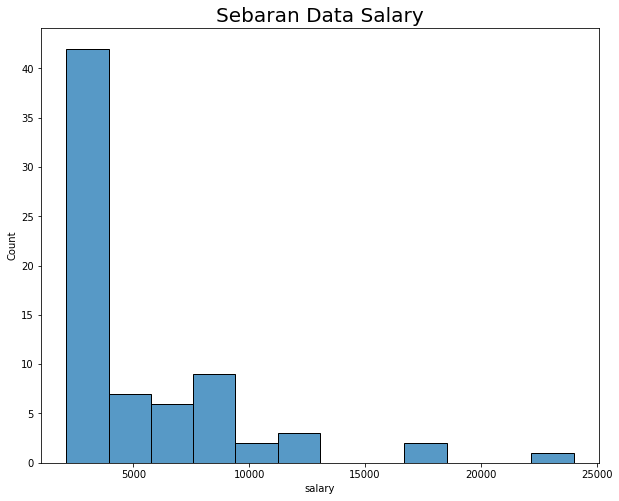

In [65]:
plt.figure(figsize=(10,8))
sns.histplot(x = tabel1['salary'])
plt.title('Sebaran Data Salary', size=20)
plt.show()

Dari histogram di atas, dapat disimpulkan bahwa salary tidak berdistribusi normal namun skew ke kanan. sehingga analisis selanjutnya menggunakan analisis non-parametric